# Demo 7 - Spike detection and sorting

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

signal = pd.read_csv('../signals/D05_signal.csv').values.flatten()

## Detection and sorting

In [113]:
pk_locs = find_peaks(np.abs(signal), height=0.3*np.max(np.abs(signal)), distance=30)[0]

spike_matrix = []
for p in pk_locs:
    spike_matrix.append(signal[p-30:p+30])
spike_matrix = np.asarray(spike_matrix).squeeze()

def peak2peak(shape_in):
    return np.ptp(shape_in)
def pos_peak(shape_in):
    return(np.max(shape_in))
def neg_peak(shape_in):
    return np.abs(np.min(shape_in))
def energy(shape_in):
    return np.sqrt(np.sum(shape_in**2))
def l_activation(shape_in):
    samples_active = np.sum(np.abs(shape_in) > 0.1*np.max(np.abs(shape_in)))
    return samples_active/shape_in.size

def extract_features(shape_in, function_list):
    
    feat_out = [f(shape_in) for f in function_list]

    return np.asarray(feat_out)

feature_list = [peak2peak, pos_peak, neg_peak, energy, l_activation]

features_all = []
for p in pk_locs:
    features_all.append(extract_features(signal[p-30:p+30], feature_list))
features_all = np.asarray(features_all)
print(features_all.shape)



(888, 5)


In [114]:
n_neurons = 3
features_to_plot = [0,3,4]

cluster = KMeans(n_clusters=n_neurons)

cluster.fit(features_all[:,features_to_plot])

KMeans(n_clusters=3)

## Check results

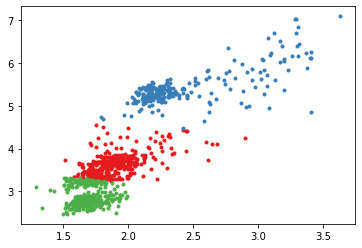

In [115]:
plt.figure()

c = plt.get_cmap('Set1')

for i in range(n_neurons):
    idx = np.where(cluster.labels_==i)[0]
    plt.plot(features_all[idx,features_to_plot[0]], features_all[idx,features_to_plot[1]], '.', c=c(i))

plt.show()

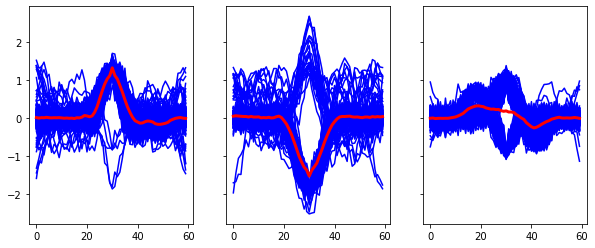

In [116]:
fig,ax = plt.subplots(1, n_neurons, figsize=(10,4), sharex=True, sharey=True)
for i in range(n_neurons):
    idx = np.where(cluster.labels_==i)[0]
    ax[i].plot(spike_matrix[idx,:].transpose(), 'b')
    ax[i].plot(np.mean(spike_matrix[idx,:], axis=0), 'r', lw=3)
plt.show()

## Outliers removal

In [117]:
idx_to_keep = np.where(features_all[:,features_to_plot[0]]<2.5)[0]
features_clean = features_all[idx_to_keep,:]
spikes_clean = spike_matrix[idx_to_keep,:]
locs_clean = pk_locs[idx_to_keep]

n_neurons = 4
cluster = KMeans(n_clusters=n_neurons)

cluster.fit(features_clean[:,features_to_plot])

KMeans(n_clusters=4)

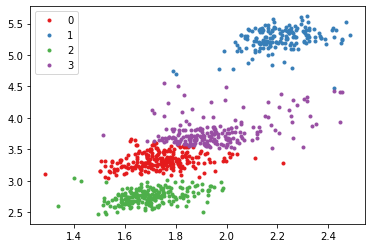

In [118]:
plt.figure()

for i in range(n_neurons):
    idx = np.where(cluster.labels_==i)[0]
    plt.plot(features_clean[idx,features_to_plot[0]], features_clean[idx,features_to_plot[1]], '.', c=c(i))
plt.legend(list(range(n_neurons)))
plt.show()

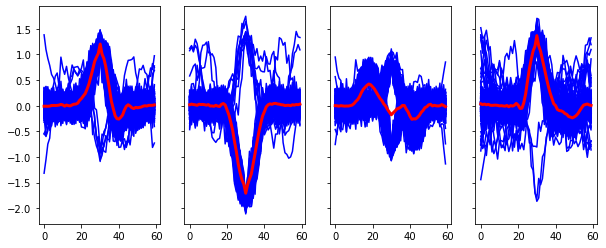

In [119]:
fig,ax = plt.subplots(1, n_neurons, figsize=(10,4), sharex=True, sharey=True)
for i in range(n_neurons):
    idx = np.where(cluster.labels_==i)[0]
    ax[i].plot(spikes_clean[idx,:].transpose(), 'b')
    ax[i].plot(np.mean(spikes_clean[idx,:], axis=0), 'r', lw=3)
plt.show()

## Calculate firing rates

In [120]:
Fs = 1e04
isi = [np.asarray(np.diff(
        locs_clean[np.where(cluster.labels_ == i)[0]]/Fs
    ))
    for i in range(n_neurons)
]

f_rates = [1/x for x in isi]
f_ths = 30
f_rates = [x[np.where(x<f_ths)[0]] for x in f_rates]

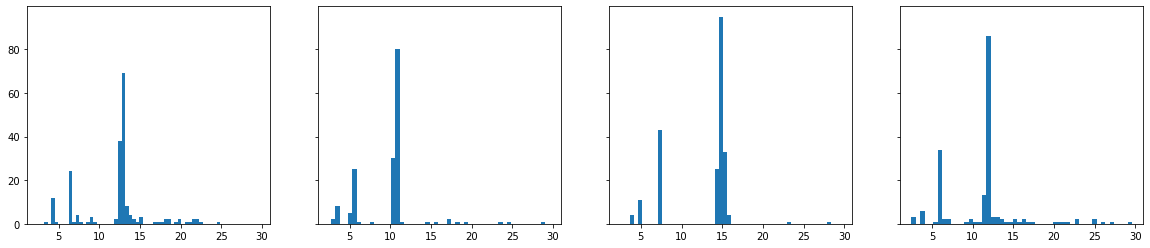

Firing rate for neuron 0: 12.7551 Hz
Firing rate for neuron 1: 10.6724 Hz
Firing rate for neuron 2: 14.7493 Hz
Firing rate for neuron 3: 11.8554 Hz


In [121]:
fig,ax = plt.subplots(1, n_neurons, figsize=(20,4), sharex=True, sharey=True)
for i in range(n_neurons):
    idx = np.where(cluster.labels_==i)[0]
    ax[i].hist(f_rates[i], bins=50)
plt.show()

for i,f in enumerate(f_rates):
    print(f'Firing rate for neuron {i}: {np.median(f):.4f} Hz')